# Compare MD Trajectory from SchNet to NWChem
See if each model captures the disassociation correctly.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.learning.gc.ase import SchnetCalculator
from ase.md.nvtberendsen import NVTBerendsen
from tempfile import TemporaryDirectory
from ase.db import connect
from ase.io import iread
from ase import Atoms, units
from pathlib import Path
import shutil
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
models = {
    'ANIx': '../0_pre-training/best_model/best_model',
    'ANIx+Initial': '../1_finetuning-for-octanol/tuned/model'
}

## Load the initial structure
Get it from the trajectory file we produced with NWChem

In [3]:
with connect('../1_finetuning-for-octanol/initial-data.db') as db:
    starting_atoms = db.get_atoms(id=1)
    traj = {'HF//6-31G*': [a.toatoms() for a in db.select('', sort='id')]}

## Perform Molecular Dynamics
Do NVT dynamics at at a temperature of 298.15K for 1000 timesteps, saving a frame at every step. Do it with each SchNet model

In [4]:
def run_md(starting_atoms: Atoms, calc, timesteps: int = 2000, temp_K: float = 298.15) -> list[Atoms]:
    """Run MD using the same procedure that we used to generate the NWChem trajectory
    
    Args:
        starting_atoms: Starting point for the run
        calc: Calculator used for forces 
        timesteps: Number of timesteps to run
    """
    
    atoms = starting_atoms.copy()
    
    with TemporaryDirectory() as tmp:
        run_dir = Path(tmp)
        
        md = NVTBerendsen(atoms, timestep=10 * units.AUT,
                  temperature_K=temp_K, taut=0.2 * units.fs,
                  logfile=str(run_dir / 'md.log'),
                  trajectory=str(run_dir / 'md.traj'))
        
        atoms.calc = calc
        md.run(timesteps)
        
        return [frame for frame in iread(run_dir / 'md.traj')]

Load then run each model

In [5]:
%%time
for name, path in models.items():
    model = torch.load(path, map_location='cpu')
    traj[name] = run_md(starting_atoms, SchnetCalculator(model))

CPU times: user 4min 34s, sys: 3.32 s, total: 4min 37s
Wall time: 23.5 s


## Compare the Trajectories
See if they are capturing the same reaction as we see in NWChem.

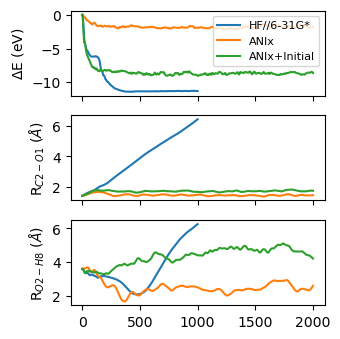

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3.5, 3.5))

for name, t in traj.items():
    # Formatting for this line
    linestyle='--' if name == 'nwchem' else '-'
    
    # Plot the energy
    e0 = t[0].get_potential_energy() 
    axs[0].plot([a.get_potential_energy() - e0 for a in t], label=name, linestyle=linestyle)
    
    # Plot the O-H bond distance
    axs[1].plot([a.get_distance(1, 2) for a in t], linestyle=linestyle)
    axs[2].plot([a.get_distance(12, 10) for a in t], linestyle=linestyle)
    
# Label the axes
axs[0].set_ylabel('$\Delta$E (eV)')
axs[1].set_ylabel('R$_{C2-O1}$ ($\\AA$)')
axs[2].set_ylabel('R$_{O2-H8}$ ($\\AA$)')
    
axs[0].legend(fontsize=8)
fig.tight_layout()

Both models appear to fail to capture disassociation. Bonds stay at equilibrium lengths. We need to gather more data